# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер



### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [ ]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

4431872/4422102 [==============================] - 0s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [ ]:
pip install catboost

     |████████████████████████████████| 76.1 MB 56 kB/s 


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)

        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.cos(X.dot(self.w) + self.b)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
# проверяем качество

model = RFFPipeline()
model.fit(x_train, y_train)
accuracy_score(model.predict(x_test), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8598

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train_loc = x_train[len(x_train)//2:]
y_train_loc = y_train[len(y_train)//2:]

In [ ]:
# случайные признаки линейное SVM

beg = time.time()

svm_linear_rand = RFFPipeline(classifier='linear')
svm_linear_rand.fit(x_train, y_train)

print("Времени на обучение линейного SVM с случайными признаками:", time.time() - beg)
print("Accuracy:", accuracy_score(svm_linear_rand.predict(x_test), y_test))

Времени на обучение линейного SVM с случайными признаками: 695.3424611091614
Accuracy: 0.8764


In [ ]:
# линейное SVM

beg = time.time()

svm_linear = SVC(kernel='linear')
svm_linear.fit(x_train_loc, y_train_loc)

print("Времени на обучение линейного SVM:", time.time() - beg)
print("Accuracy:", accuracy_score(svm_linear.predict(x_test), y_test))

Времени на обучение линейного SVM: 322.5119731426239
Accuracy: 0.819


Подход с случайными признаками дает значительно лучшее качество (и в целом оно неплохое), но работает в два раза дольше. Если у нас есть достаточно времени, то случайны признаки --- тут хороший вариант.

In [ ]:
# случайные признаки SVM ядровой

beg = time.time()

svm_rbf_rand = RFFPipeline(classifier='rbf')
svm_rbf_rand.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на обучение ярового SVM с случайными признаками:", time.time() - beg)
print("Accuracy:", accuracy_score(svm_rbf_rand.predict(x_test), y_test))

Времени потребовалось на обучение ярового SVM с случайными признаками: 209.55411887168884
Accuracy: 0.8525


In [ ]:
# SVM ядровой

beg = time.time()

svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на обучение SVM ядрового:", time.time() - beg)
print("Accuracy:", accuracy_score(svm_rbf.predict(x_test), y_test))

Времени потребовалось на обучение SVM ядрового: 254.82953596115112
Accuracy: 0.8771


Время работы и качество примерно одинаковые: ядровой SVM работает чуть лучше, но и чуть дольше. Разница некритичная, но смысла в нашем подходе, получается, нет.

In [ ]:
# PCA -> CatBoost с подбором числа деревьев и длины шага

beg = time.time()

# PCA
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train_loc)
x_test_pca = pca.transform(x_test)

# подбор числа деревьев и длины шага
params = {'n_estimators': [10, 100, 500, 700], 
          'learning_rate': [0.01, 0.1, 0.5, 1]
         }
cb = GridSearchCV(CatBoostClassifier(silent=True), param_grid=params, cv=3, scoring='accuracy')
cb.fit(x_train_pca, y_train_loc)

# обучим лучший catboost 
best_params = cb.best_params_
best_cb = CatBoostClassifier(**best_params)
best_cb.fit(x_train_pca, y_train_loc)

print('Понадобилось времени на PCA + catboost с подбором числа деревьев и длины шага:', time.time() - beg)
print("Accuracy: ", accuracy_score(best_cb.predict(x_test_pca), y_test))

0:	learn: 1.9588269	total: 260ms	remaining: 3m 1s
1:	learn: 1.7513725	total: 511ms	remaining: 2m 58s
2:	learn: 1.6088840	total: 760ms	remaining: 2m 56s
3:	learn: 1.4857346	total: 1.01s	remaining: 2m 56s
4:	learn: 1.3876744	total: 1.27s	remaining: 2m 57s
5:	learn: 1.3072378	total: 1.53s	remaining: 2m 56s
6:	learn: 1.2393376	total: 1.78s	remaining: 2m 56s
7:	learn: 1.1872977	total: 2.03s	remaining: 2m 55s
8:	learn: 1.1307318	total: 2.29s	remaining: 2m 55s
9:	learn: 1.0796910	total: 2.54s	remaining: 2m 55s
10:	learn: 1.0379984	total: 2.79s	remaining: 2m 54s
11:	learn: 0.9991147	total: 3.05s	remaining: 2m 54s
12:	learn: 0.9684338	total: 3.32s	remaining: 2m 55s
13:	learn: 0.9377863	total: 3.57s	remaining: 2m 55s
14:	learn: 0.9073305	total: 3.83s	remaining: 2m 55s
15:	learn: 0.8807186	total: 4.1s	remaining: 2m 55s
16:	learn: 0.8595618	total: 4.37s	remaining: 2m 55s
17:	learn: 0.8375598	total: 4.63s	remaining: 2m 55s
18:	learn: 0.8176664	total: 4.89s	remaining: 2m 55s
19:	learn: 0.8035617	tot

Работает значительно дольше, чем подход со случайными признаками. Результат дает хороший, хотя мы ядровым SVM со случайными признаками можем получить результат лучше за всего 209 секунд. Поэтому такое большое время работы не оправдано, и подход со случайными признаками лучше.

Получается, что подход со случайными признаками в целом оправданный: дает хорошее качество и работает за хорошее время (да, для линейного SVM время ожидания было в два раза больше, но не катастрофичное, можно подождать для хорошего результата. Или в одном случае мы получаем результат примерно такой же), можно брать в рассмотрение и пробовать!

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

In [ ]:
# поиск сигмы через цикл для озу
from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)

        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def sigma_2_for(self, X):
      sigmas = []
      for _ in range(1000000):
        i, j = np.random.randint(0, X.shape[0], size=2)
        if i != j:
          sigmas.append(np.linalg.norm(X[i] - X[j])**2)
      return np.median(sigmas)

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.cos(X.dot(self.w) + self.b)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2_for(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
# 1

# kernel SVM

beg = time.time()

without_pca = RFFPipeline(classifier='rbf', use_PCA=False)
without_pca.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на kernel SVM без PCA:", time.time() - beg)
print("Accuracy:", accuracy_score(without_pca.predict(x_test), y_test))

beg = time.time()

with_pca = RFFPipeline(classifier='rbf', use_PCA=True)
with_pca.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на kernel SVM с PCA:", time.time() - beg)
print("Accuracy:", accuracy_score(with_pca.predict(x_test), y_test))

Времени потребовалось на kernel SVM без PCA: 209.0069181919098
Accuracy: 0.8668
Времени потребовалось на kernel SVM с PCA: 189.69252824783325
Accuracy: 0.8547


PCA чуть ускорило выполнение и чуть-чуть испортило качество. Не похоже, что использовать или нет особо имеет значение.

In [ ]:
# linear SVM

beg = time.time()

without_pca = RFFPipeline(classifier='linear', use_PCA=False)
without_pca.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на SVM без PCA:", time.time() - beg)
print("Accuracy:", accuracy_score(without_pca.predict(x_test), y_test))

beg = time.time()

with_pca = RFFPipeline(classifier='linear', use_PCA=True)
with_pca.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на SVM c PCA:", time.time() - beg)
print("Accuracy:", accuracy_score(with_pca.predict(x_test), y_test))

Времени потребовалось на SVM без PCA: 196.2081913948059
Accuracy: 0.8397
Времени потребовалось на SVM c PCA: 176.56715750694275
Accuracy: 0.8675


PCA ускорило работу алгоритма и улучшило качество. Использование однозначно оправдано.

In [ ]:
# logreg
beg = time.time()

without_pca = RFFPipeline(classifier='logreg', use_PCA=False)
without_pca.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на logreg без PCA:", time.time() - beg)
print("Accuracy:", accuracy_score(without_pca.predict(x_test), y_test))

beg = time.time()

with_pca = RFFPipeline(classifier='logreg', use_PCA=True)
with_pca.fit(x_train_loc, y_train_loc)

print("Времени потребовалось на logreg c PCA:", time.time() - beg)
print("Accuracy:", accuracy_score(with_pca.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Времени потребовалось на logreg без PCA: 68.27404165267944
Accuracy: 0.8501


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Времени потребовалось на logreg c PCA: 66.47967100143433
Accuracy: 0.8554


(извините, что не отключила ворнинги))

PCA чуть ускорило работу и чуть улучшило качество. Изменения некритичные, конечно, но и не  худшую сторону))

Общий вывод: использование оправдано, ведь PCA или хорошо улучшает качество и время работы, или почти не меняет эти показатели.

In [ ]:
# 2

# logreg

acc_logreg = []
n_feat = np.linspace(10, 3000, 50, dtype=int)

for feat in n_feat:
    model = RFFPipeline(classifier='logreg', n_features=feat)
    model.fit(x_train_loc, y_train_loc)
    acc_logreg.append(accuracy_score(model.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Text(0, 0.5, 'accuracy')

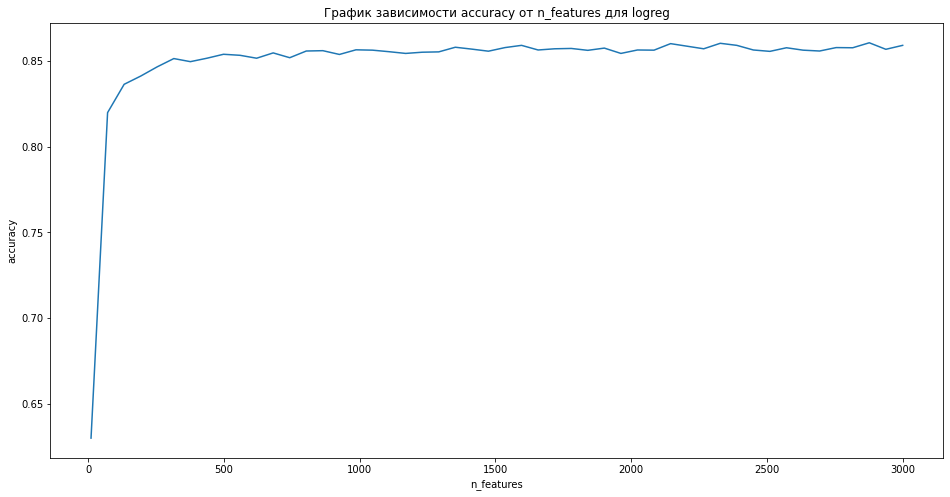

In [ ]:
# accuracy от n_features
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('График зависимости accuracy от n_features для logreg')
plt.plot(np.linspace(10, 3000, 50, dtype=int), acc_logreg)
plt.xlabel('n_features')
plt.ylabel('accuracy')

Видим, что с ростом n_features где-то до 350 качество растет, а потом выходит на плато.

In [ ]:
# linear SVM

acc_linSVM = []
n_feat = np.linspace(10, 3000, 50, dtype=int)

for feat in n_feat:
    model = RFFPipeline(classifier='linear', n_features=feat)
    model.fit(x_train_loc, y_train_loc)
    acc_linSVM.append(accuracy_score(model.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Text(0, 0.5, 'accuracy')


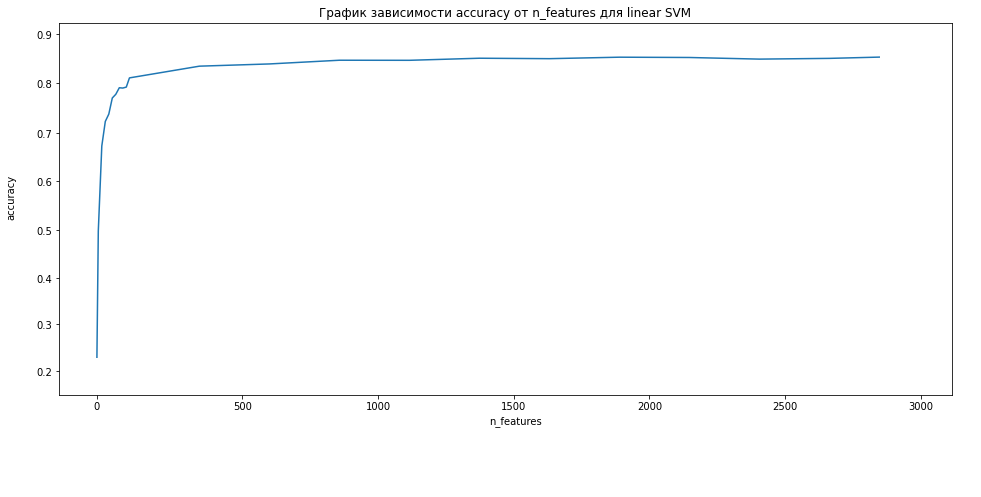

In [7]:
plt.figure(figsize=(16, 8))
plt.title('График зависимости accuracy от n_features для linear SVM')
plt.plot(np.linspace(10, 3000, 50, dtype=int), acc_linSVM)
plt.xlabel('n_features')
plt.ylabel('accuracy')

Точно то же: качество поднимается где-то до 350, потом выходт на плато.

\#3

Регрессия работает значительно быстрее, но при SVM качество чуть лучше (не соизмеримо с увеличением длительности работы). Таким образом, разница есть, если нам важно время работы. Если нет, то скорее нет.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

$$W_{ORF} = \frac{1}{\sigma} SQ$$

Q --- равномерно распределенная ортогональная матрица из QR-разложения матрицы Гаусса. S --- диагональная с $\chi$-распределением на диагонали.

Замечание: если n_features < new_dim, то используем первые new_dim D столбцов. Иначе мы используем несколько независимо сгенерированных случайных объектов и объединяем результаты.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)

        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.cos(X.dot(self.w.T) + self.b)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)

        G = np.random.normal(size=(self.n_features, self.new_dim))
        S, _ = np.linalg.qr(G)
        Q = np.diag(np.sqrt(np.random.chisquare(self.new_dim, self.new_dim)))

        self.w = 1 / np.sqrt(self.sigma) * np.dot(S, Q)
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
beg = time.time()

ORF_logreg = ORFPipeline(classifier='logreg')
ORF_logreg.fit(x_train_loc, y_train_loc)

print("Времени потребовалось:", time.time() - beg)
print("Accuracy:", accuracy_score(ORF_logreg.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Времени потребовалось: 47.03280067443848
Accuracy: 0.8048


напомним результаты RFF с logreg: работало за 66.48 сек, качество 0.86. Получается, ORF ухудшило качество, но ускорило работу.

In [ ]:
beg = time.time()

ORF_linear = ORFPipeline(classifier='linear', use_PCA=True)
ORF_linear.fit(x_train_loc, y_train_loc)

print("Времени потребовалось:", time.time() - beg)
print("Accuracy:", accuracy_score(ORF_linear.predict(x_test), y_test))

Времени потребовалось: 166.7388105392456
Accuracy: 0.8494


Напомним результаты RFF с линейным SVM: работает за 176.6 сек с качеством 0.87. Т.е. качество ухудшилось, а время чуть уменьшилось.

In [ ]:
beg = time.time()

ORF_rbf = ORFPipeline(classifier='rbf', use_PCA=True)
ORF_rbf.fit(x_train_loc, y_train_loc)

print("Времени потребовалось:", time.time() - beg)
print("Accuracy:", accuracy_score(ORF_rbf.predict(x_test), y_test))

Времени потребовалось: 308.3632354736328
Accuracy: 0.7986


Напомним результаты RFF с ядровым SVM: работает за 189.7 сек с качеством 0.85. RFF работает и значительно быстрее, и с лучшим качеством. Тут совсем провал: и дольше, и качество хуже.

Общий вывод: тут не подошло. Нам лучше подходит RFF.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# знак

from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)

        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.sign(X.dot(self.w) + self.b)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
beg = time.time()

sign_model = RFFPipeline()
sign_model.fit(x_train_loc, y_train_loc)

print("Выполняется за", time.time() - beg)
print("Accuracy:", accuracy_score(sign_model.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Выполняется за 42.32986354827881
Accuracy: 0.8216


In [ ]:
# exp

from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)

        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.exp(X.dot(self.w) + self.b)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
beg = time.time()

exp_model = RFFPipeline()
exp_model.fit(x_train_loc, y_train_loc)

print("Выполняется за", time.time() - beg)
print("Accuracy:", accuracy_score(exp_model.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Выполняется за 64.60627508163452
Accuracy: 0.8113


In [ ]:
# log

from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)

        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.log(np.abs(X.dot(self.w) + self.b))

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
beg = time.time()

log_model = RFFPipeline()
log_model.fit(x_train_loc, y_train_loc)

print("Выполняется за", time.time() - beg)
print("Accuracy:", accuracy_score(log_model.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Выполняется за 43.64604830741882
Accuracy: 0.8309


In [ ]:
# sin(exp)

from sklearn.base import BaseEstimator, TransformerMixin

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg'):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)

        self.classifier = classifier
        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        else:
            self.model = SVC(kernel=self.classifier)
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.sin(np.exp(X.dot(self.w) + self.b))

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
beg = time.time()

sinexp_model = RFFPipeline()
sinexp_model.fit(x_train_loc, y_train_loc)

print("Выполняется за", time.time() - beg)
print("Accuracy:", accuracy_score(sinexp_model.predict(x_test), y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Выполняется за 43.79927086830139
Accuracy: 0.8327


In [ ]:
# DecisionTree

from sklearn.base import BaseEstimator, TransformerMixin

class DecisionTreePipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)
        self.model = DecisionTreeClassifier()
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.cos(X.dot(self.w) + self.b)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
beg = time.time()

tree_model = DecisionTreePipeline()
tree_model.fit(x_train_loc, y_train_loc)

print("Выполняется за", time.time() - beg)
print("Accuracy:", accuracy_score(tree_model.predict(x_test), y_test))

Выполняется за 112.11686778068542
Accuracy: 0.7508


In [ ]:
# RidgeClassifier

from sklearn.base import BaseEstimator, TransformerMixin

class RidgePipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.new_dim = new_dim

        self.use_PCA = use_PCA
        self.PCA = PCA(n_components=self.new_dim)
        self.model = RidgeClassifier()
  
    def sigma_2(self, X):
        # получим миллион пар (i_k, j_k)
        i = np.random.choice(X.shape[0], size=1000000)
        j = np.random.choice(X.shape[0], size=1000000)

        # но некоторые могут быть вида (i, i), их нельзя сравнивать. просто выкинем
        # т.к X достаточно большой, сильно на числе пар это не отразится
        i, j = i[i!=j], j[i!=j]

        # результат
        return np.median(np.sum((X[i] - X[j])**2, axis=1))

    def use_PCA_func(self, X):
        if self.use_PCA:
            X = self.PCA.transform(X)
        else:
            self.new_dim = X.shape[1]
        return X

    def new_feat(self, X):
      return np.cos(X.dot(self.w) + self.b)

    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.PCA.fit(X)
        X = self.use_PCA_func(X)

        self.sigma = self.sigma_2(X)
        self.w = np.random.normal(0, 1/np.sqrt(self.sigma), size=(self.new_dim, self.n_features))
        self.b = np.random.uniform(-np.pi, np.pi, size=self.n_features)

        new_X = self.new_feat(X)
        self.model.fit(new_X, y)
        
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict_proba(new_X) 
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.use_PCA_func(X)
        new_X = self.new_feat(X)
        return self.model.predict(new_X)

In [ ]:
beg = time.time()

ridge_model = RidgePipeline()
ridge_model.fit(x_train_loc, y_train_loc)

print("Выполняется за", time.time() - beg)
print("Accuracy:", accuracy_score(ridge_model.predict(x_test), y_test))

Выполняется за 8.174607276916504
Accuracy: 0.8497


Все новые признаки придумала такие себе: качество на них не лучше, хотя работают быстрее. Например, для sin + exp получали качество 0.83 за 43 секунды, наши методы дольше работают. Лучше всего по качеству из наших новых вариантов показала себя Ridge-регрессия. К тому же время работы очень маленькое. Нашим исходным методом мы получаем лучший резутат 0.87, но за значительно большее время --- 600 секунд. Так что Ridge --- идеальный баланс между временем работы и качеством.